In [110]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import scipy.io as sio
import numpy as np
import cv2

def load_data(path, root, output_dir):
    data = sio.loadmat(os.path.join(output_dir, 'H' + path.split('.')[0].split('rgb')[1] + '.mat'))
    return np.array(Image.open(os.path.join(root, path))), data['H']

# Panorama
ref_image = 1
input_dir = '/DATASETS/viana1'
output_dir = 'Output_viana1'

# Run project code
os.system('python3 pivproject2022_task2.py %d %s %s' %(ref_image, input_dir, output_dir))

print('finished running code')

finished running code


In [111]:
ims, limits, Hs = [], [], []
for fname in sorted(os.listdir(input_dir)):
    if fname.endswith('.jpg') or fname.endswith('.png'):
        im, H = load_data(fname, input_dir, output_dir)
        
        if not(np.array_equal(H, np.zeros((3,3)))):
            s1,s2,s3 = im.shape
            ims.append(im)
            Hs.append(H)
            
            # Get limits
            corners = np.array([[0,0,1],[0,s1,1],[s2,s1,1],[s2,0,1]])
            nc = np.matmul(corners,H.T)
            limits.append(nc[:,0:2]/nc[:,2:3])

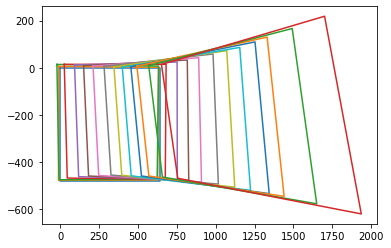

In [112]:
# Find limits of panorama
lims = np.concatenate(limits,axis=0)
minx, maxx = lims[:,0].min(), lims[:,0].max()
miny, maxy = lims[:,1].min(), lims[:,1].max()

for i in range(int(lims.shape[0]/4)):
    lims_i = np.concatenate((lims[4*i:4 + 4*i], lims[None, 4*i, :]), axis = 0)
    plt.plot(lims_i[:, 0], -lims_i[:,1])
plt.show()
    
#plt.plot(lims[:,0],lims[:,1])

width_canvas = maxx - minx + 1
height_canvas = maxy - miny + 1
    
canvas_img = np.zeros((int(height_canvas), int(width_canvas), 3), dtype=np.int64)

# Correct homography to be within image limits
From the figure above it's easy to compute a transformation (homography ?) to apply to all images (homographies !) 
so that the warped image as positive coordinates in order to fit in an array. In other words, xmin and ymin should be mapped to (0,0).
Also you can include a scaling factor to make the mosaic smaller.


In [113]:
warped_images = {}

for i in range(len(Hs)):
    H = Hs[i]
    image = ims[i]
    
    translation_mat = np.array([[1, 0, -minx], [0, 1, -miny], [0, 0, 1]])
    H = np.dot(translation_mat, H)
    warped_images[i] = cv2.warpPerspective(image, H, (canvas_img.shape[1], canvas_img.shape[0]), flags = cv2.INTER_NEAREST)

# Final Output 
After computing the final transformation of all images to an array (the final panorama) the output can be generated with opencv function
cv2.warpPerspective. After warping all images you can blend them. Suggestion is a simple criterion (average, max, the last pixel...keep it simple!).

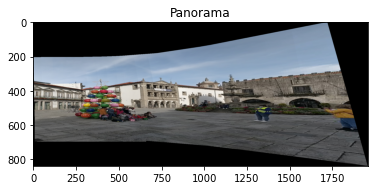

In [114]:
panorama_image = warped_images[0] 

for i in range(1,len(warped_images)):    
    img1 = np.float32(panorama_image)
    img2 = np.float32(warped_images[i])
    
    mask_a = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    mask_b = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
        
    a_and_b = cv2.bitwise_and(mask_a, mask_b)
    overlap_area_mask = cv2.threshold(a_and_b, 1, 255, cv2.THRESH_BINARY)[1]
        
    overlap_pixels = (cv2.bitwise_and(img1, img1, mask = overlap_area_mask.astype('uint8')) + cv2.bitwise_and(img2, img2, mask = overlap_area_mask.astype('uint8')))/2
        
    panorama_image = cv2.bitwise_and(img1, img1, mask = np.logical_not(overlap_area_mask).astype('uint8')) + cv2.bitwise_and(img2, img2, mask = np.logical_not(overlap_area_mask).astype('uint8')) + overlap_pixels
                
panorama_image = panorama_image.astype('uint8')
        
plt.title("Panorama")
plt.imshow(panorama_image)
plt.show()
        